In [1]:
# %load_ext autoreload
# %autoreload 2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import ccf_plots as cplots
import ccf_images as cimg
import abc_load as abc
get_ipython().run_line_magic('matplotlib', 'inline') 

# Load brain3 data

In [2]:
obs = abc.get_combined_metadata(realigned=True, version="20230830", drop_unused=False)


In [3]:
# add parcellation index
imdata = abc.get_ccf_labels_image(resampled=False)

In [4]:
imdata.shape

(1320, 800, 1140)

In [ ]:

ccf_polygons = abc.get_ccf_labels_image(resampled=True, realigned=True)
ccf_label = 'parcellation_substructure_realigned'
ccf_boundaries = cimg.sectionwise_label_erosion(ccf_polygons, distance_px=1, fill_val=0, return_edges=True)

### preprocessing

In [4]:
th_names = abc.get_thalamus_substructure_names()
th_subregion_names = list(set(th_names).difference(['TH-unassigned']))

In [5]:
# subset just the neurons
# maybe change this to actually take out only non-neuronal?
# obs_neurons = abc.filter_adata_by_class(obs, filter_midbrain=False)
nn_classes = [
    "31 OPC-Oligo",
    "30 Astro-Epen",
    "33 Vascular",
    "34 Immune",
]
# subset just the neurons
obs_neurons = obs[~obs['class'].isin(nn_classes)]

# filter to CCF 
# does not include fiber tracts etc 
# obs_th = obs[obs[ccf_label].isin(th_names)]
# using outline with small buffer
obs_th = abc.label_thalamus_spatial_subset(obs, distance_px=5, realigned=True, filter_cells=True)


In [6]:
obs_th_neurons = obs.loc[obs_neurons.index.intersection(obs_th.index)]
# helps plotting etc by trimming categories
obs_th_neurons = obs_th_neurons.assign(
    **obs_th_neurons.select_dtypes(include=["category"])
    .apply(lambda x: x.cat.remove_unused_categories())
    .to_dict(orient='series'))

In [7]:
section_col = 'z_section'
x_coord_col = 'x_section'
y_coord_col = 'y_section'

sections_all = sorted(obs_th_neurons[section_col].unique())
# pick 3 example sections
sections_3 = [6.4, 7.2, 8.0]

## view CCF

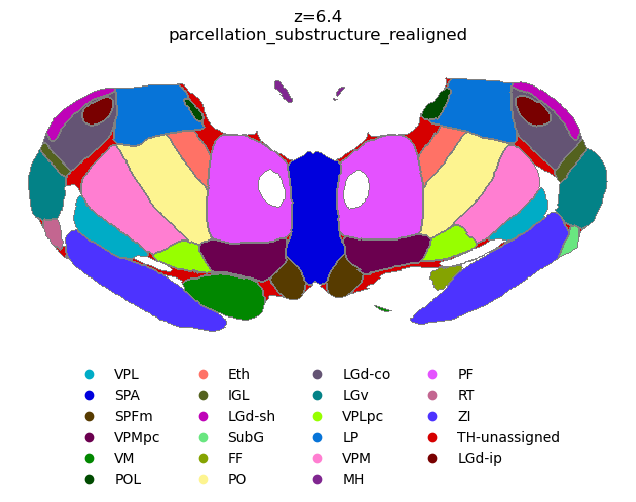

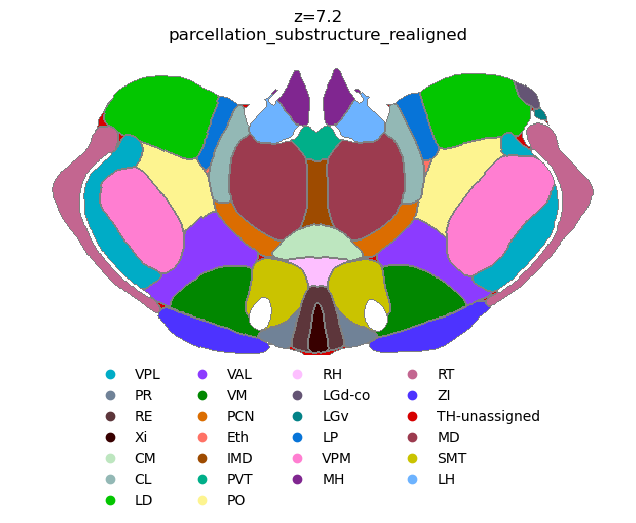

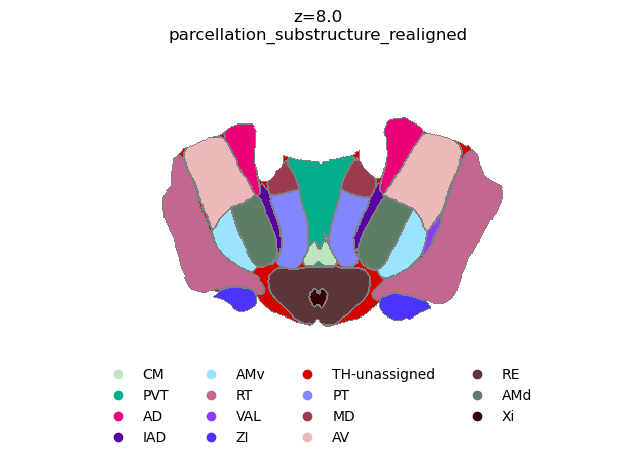

[<Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>]

In [8]:
cplots.plot_ccf_overlay(obs_th_neurons.iloc[[],:], # no foreground cells; just the ccf shapes
                        ccf_polygons, sections=sections_3, point_hue=ccf_label, 
                        highlight='all', legend='ccf',
                        section_col=section_col, x_col=x_coord_col, y_col=y_coord_col,
                        bg_shapes=False, min_group_count=0, 
                        axes=False)

## view taxonomy labels over CCF

### select thalamus celltype subsets

In [9]:
obs_th['class'].value_counts().loc[lambda x: x>40]

class
18 TH Glut         57730
31 OPC-Oligo       37929
30 Astro-Epen      28403
33 Vascular        19546
12 HY GABA         13372
17 MH-LH Glut       5650
19 MB Glut          5418
20 MB GABA          3094
34 Immune           1909
14 HY Glut           561
13 CNU-HYa Glut      509
04 DG-IMN Glut       321
01 IT-ET Glut        320
11 CNU-HYa GABA      214
21 MB Dopa           203
27 MY GABA           154
03 OB-CR Glut        107
24 MY Glut            93
07 CTX-MGE GABA       54
Name: count, dtype: int64

In [10]:
obs_th_neurons['class'].value_counts()

class
18 TH Glut         57730
12 HY GABA         13372
17 MH-LH Glut       5650
19 MB Glut          5418
20 MB GABA          3094
14 HY Glut           561
13 CNU-HYa Glut      509
04 DG-IMN Glut       321
01 IT-ET Glut        320
11 CNU-HYa GABA      214
21 MB Dopa           203
27 MY GABA           154
03 OB-CR Glut        107
24 MY Glut            93
07 CTX-MGE GABA       54
06 CTX-CGE GABA       29
09 CNU-LGE GABA       21
08 CNU-MGE GABA       19
28 CB GABA            16
23 P Glut             11
26 P GABA             10
10 LSX GABA            2
16 HY MM Glut          2
05 OB-IMN GABA         1
Name: count, dtype: int64

In [11]:
th_subclasses = obs_th_neurons['subclass'].value_counts().loc[lambda x: x>400]
th_subclasses

subclass
151 TH Prkcd Grin2c Glut                  38863
093 RT-ZI Gnb3 Gaba                        7358
145 MH Tac2 Glut                           4625
101 ZI Pax6 Gaba                           4220
154 PF Fzd5 Glut                           4042
149 PVT-PT Ntrk1 Glut                      4036
152 RE-Xi Nox4 Glut                        3764
168 SPA-SPFm-SPFp-POL-PIL-PoT Sp9 Glut     3563
150 CM-IAD-CL-PCN Sema5b Glut              3492
148 AV Col27a1 Glut                        1688
203 LGv-SPFp-SPFm Nkx2-2 Tcf7l2 Gaba       1620
109 LGv-ZI Otx2 Gaba                       1245
147 AD Serpinb7 Glut                       1172
146 LH Pou4f1 Sox1 Glut                    1025
153 MG-POL-SGN Nts Glut                     673
202 PRT Tcf7l2 Gaba                         550
164 APN C1ql4 Glut                          522
163 APN C1ql2 Glut                          501
167 PRC-PAG Tcf7l2 Irx2 Glut                438
197 SNr Six3 Gaba                           425
Name: count, dtype: int64

In [12]:
len(th_subclasses)

20

In [13]:
obs_th_neurons.loc[lambda df: df['subclass'].isin(th_subclasses.index), 'class'].value_counts().loc[lambda x: x>0]

class
18 TH Glut       57730
12 HY GABA       12823
17 MH-LH Glut     5650
19 MB Glut        5024
20 MB GABA        2595
Name: count, dtype: int64

In [14]:
obs_th_neurons.loc[lambda df: df['subclass'].isin(th_subclasses.index), 'supertype'].unique().shape[0]

95

In [15]:
obs_th_neurons.loc[lambda df: df['subclass'].isin(th_subclasses.index), 'cluster'].unique().shape[0]

441

In [16]:
subclasses_all = obs_th_neurons['subclass'].value_counts().loc[lambda x: x>100]
print(len(subclasses_all))

supertypes_all = obs_th_neurons['supertype'].value_counts().loc[lambda x: x>10]
print(len(supertypes_all))

34
156


In [17]:
obs_th_neurons.loc[lambda df: df['subclass'].isin(subclasses_all.index), 'class'].value_counts().loc[lambda x: x>0]

class
18 TH Glut         57730
12 HY GABA         13276
17 MH-LH Glut       5650
19 MB Glut          5144
20 MB GABA          2889
13 CNU-HYa Glut      346
04 DG-IMN Glut       314
01 IT-ET Glut        313
14 HY Glut           285
21 MB Dopa           203
27 MY GABA           138
03 OB-CR Glut        107
Name: count, dtype: int64

In [18]:
obs_th_neurons.loc[lambda df: df['subclass'].isin(subclasses_all.index), 'supertype'].unique().shape[0]

140

In [19]:
obs_th_neurons.loc[lambda df: df['subclass'].isin(subclasses_all.index), 'cluster'].unique().shape[0]

570

### Plots

In [20]:

palette_subclass = abc.get_taxonomy_palette('subclass')
palette_supertype = abc.get_taxonomy_palette('supertype')
palette_cluster = abc.get_taxonomy_palette('cluster')


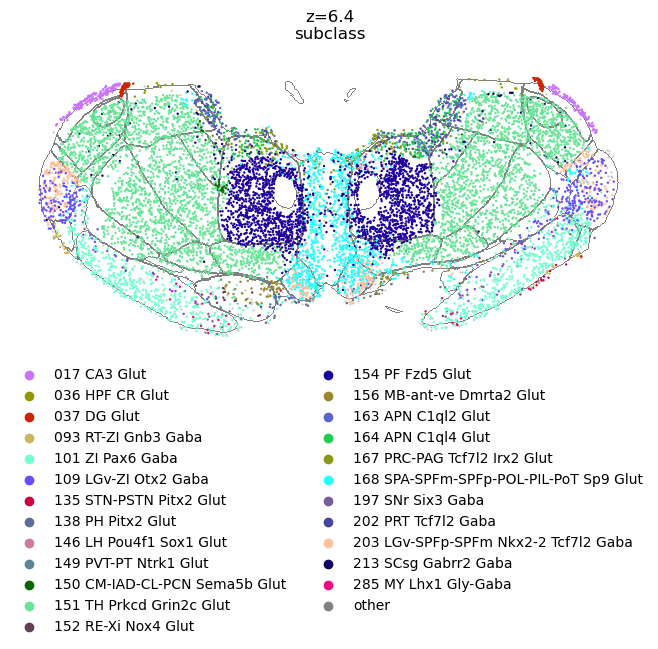

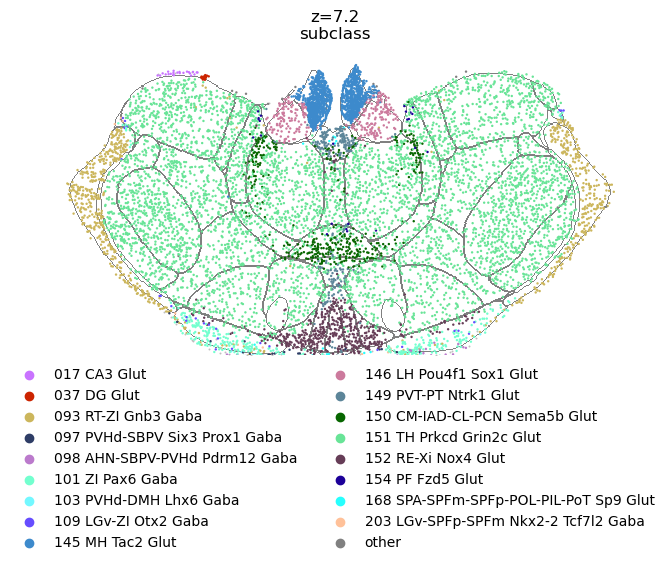

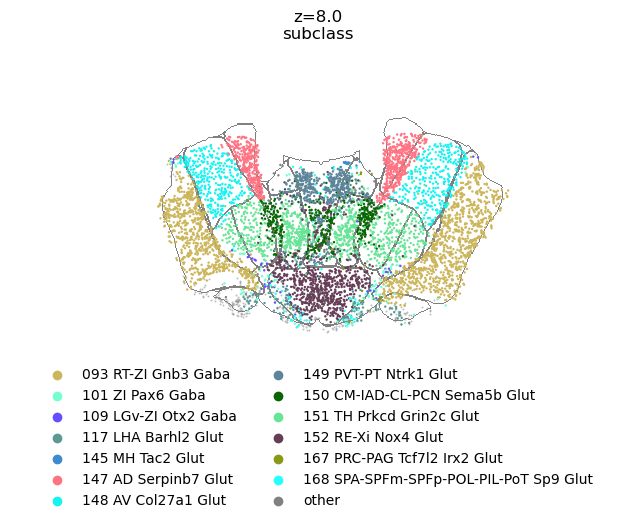

[<Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>]

In [29]:
obs = obs_th_neurons.loc[lambda df: df['subclass'].isin(subclasses_all.index)]
point_palette = palette_subclass
cplots.plot_ccf_overlay(obs, ccf_polygons, 
                        bg_cells=obs_th_neurons, # skip the background cells - it just makes it look like a grey 3D shadow on each dot
                        point_hue='subclass', sections=sections_3,
                        shape_palette='dark_outline', 
                        point_palette=point_palette, legend='cells', 
                        highlight='all', section_col=section_col, 
                        x_col=x_coord_col, y_col=y_coord_col,
                        min_group_count=10, s=3)

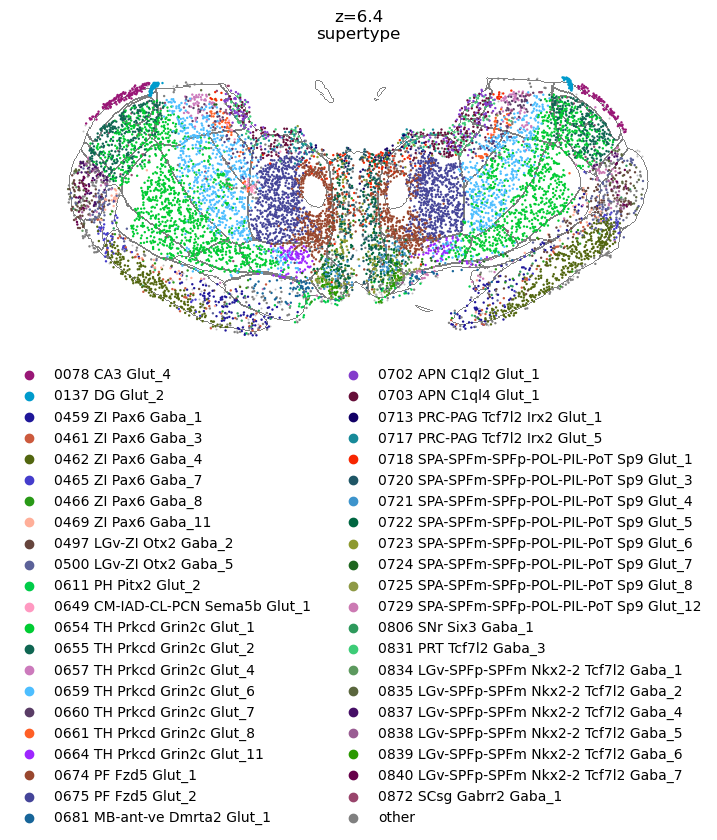

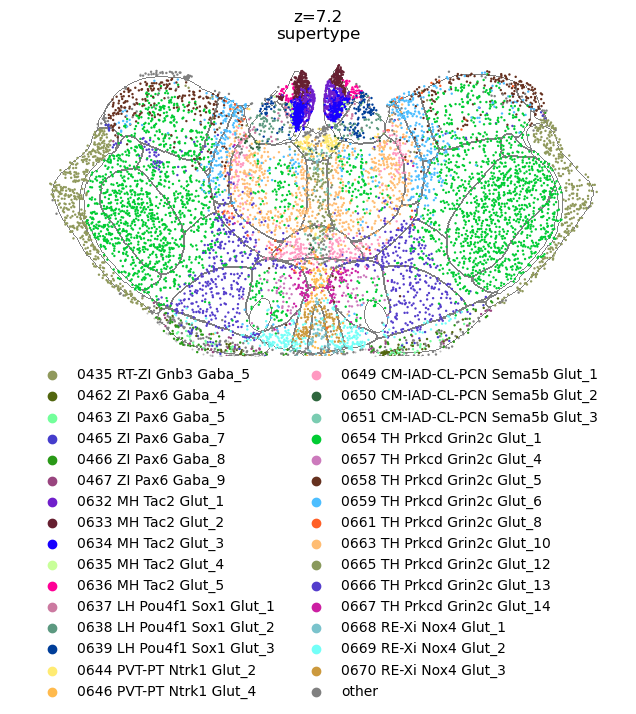

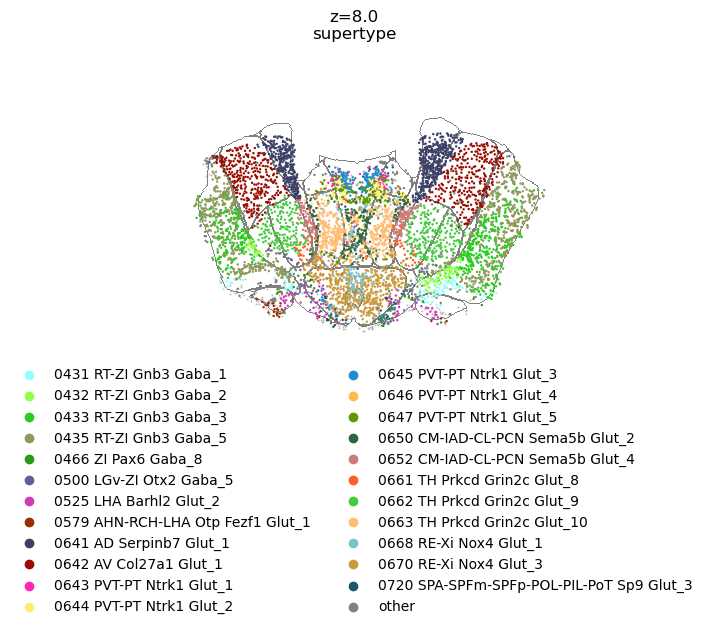

[<Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>]

In [30]:
obs = obs_th_neurons.loc[lambda df: df['supertype'].isin(supertypes_all.index)]
point_palette = palette_supertype
cplots.plot_ccf_overlay(obs, ccf_polygons, 
                        bg_cells=obs_th_neurons, # skip the background cells - it just makes it look like a grey 3D shadow on each dot
                        point_hue='supertype', sections=sections_3,
                        shape_palette='dark_outline', 
                        point_palette=point_palette, legend='cells', 
                        highlight='all', section_col=section_col, 
                        x_col=x_coord_col, y_col=y_coord_col,
                        min_group_count=30, s=3)

## specific nuclei examples

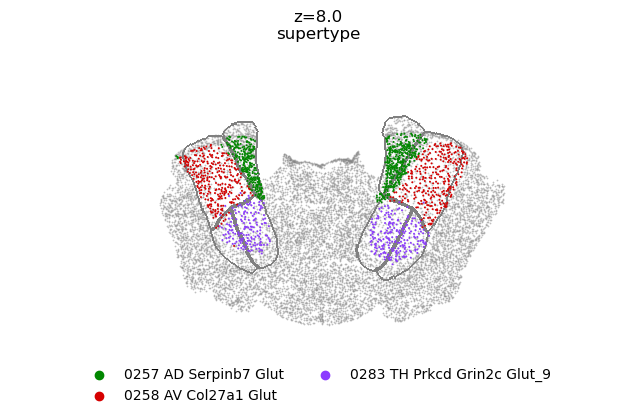

In [ ]:
anterior_sec = 8.0
clusters = [str(x) for x in list(range(1169, 1171+1)) + list(range(1095, 1098+1))]
obs = obs_th_neurons.loc[lambda df: df['cluster'].str[:4].isin(clusters)]
nuclei = ['AD', 'AV', 'AMd', 'AMv']
cplots.plot_ccf_overlay(obs, ccf_polygons, bg_cells=obs_th, point_hue='supertype', sections=[anterior_sec],
                 shape_palette='dark_outline',
                 ccf_names=nuclei, legend='cells', bg_shapes=False, 
                 section_col=section_col)

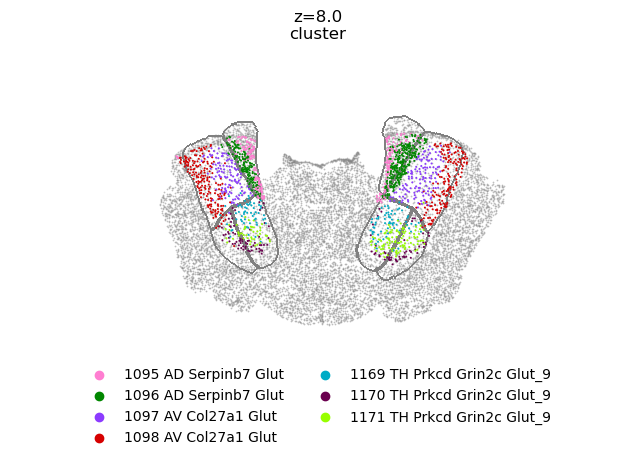

In [ ]:

cplots.plot_ccf_overlay(obs, ccf_polygons, bg_cells=obs_th, point_hue='cluster', sections=[anterior_sec],
                 shape_palette='dark_outline',
                 ccf_names=nuclei, legend='cells', bg_shapes=False, 
                 section_col=section_col)

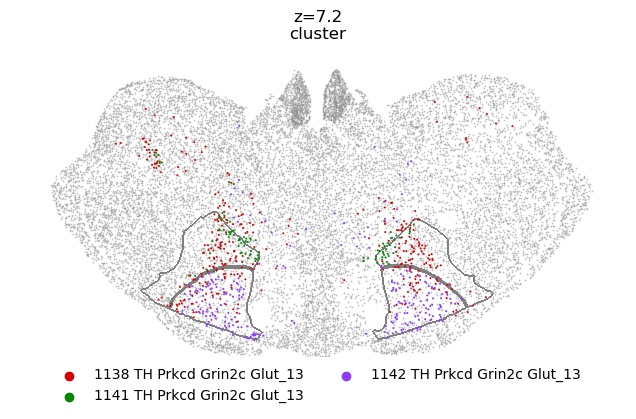

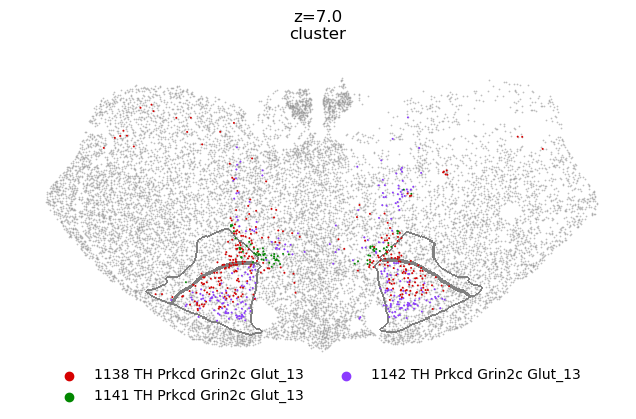

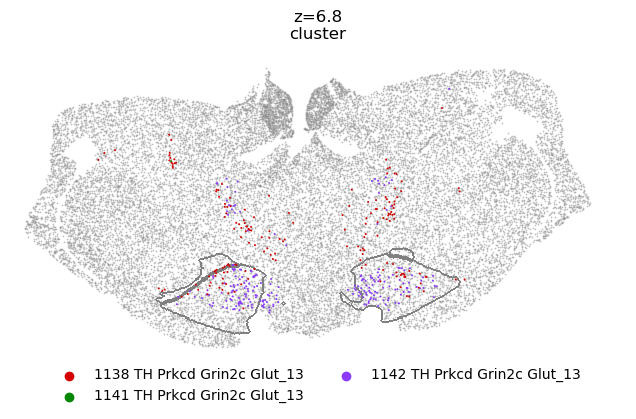

In [ ]:
sections = [7.2, 7.0, 6.8]
clusters = ['1138','1141','1142']
obs = obs_th_neurons.loc[lambda df: df['cluster'].str[:4].isin(clusters)]
nuclei = ['VM','VAL']
cplots.plot_ccf_overlay(obs, ccf_polygons, bg_cells=obs_th, point_hue='cluster', sections=sections,
                 shape_palette='dark_outline',
                 ccf_names=nuclei, legend='cells', bg_shapes=False, 
                 section_col=section_col)

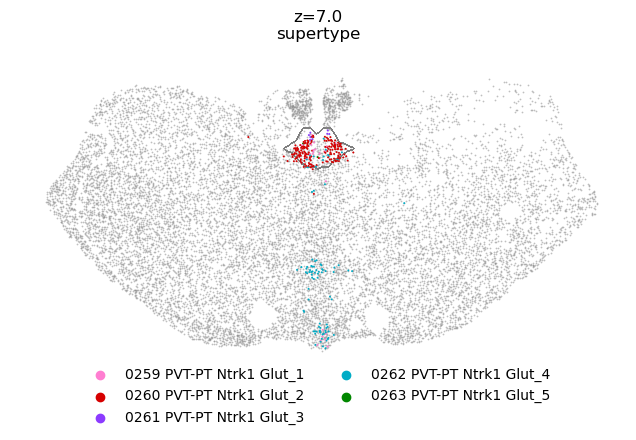

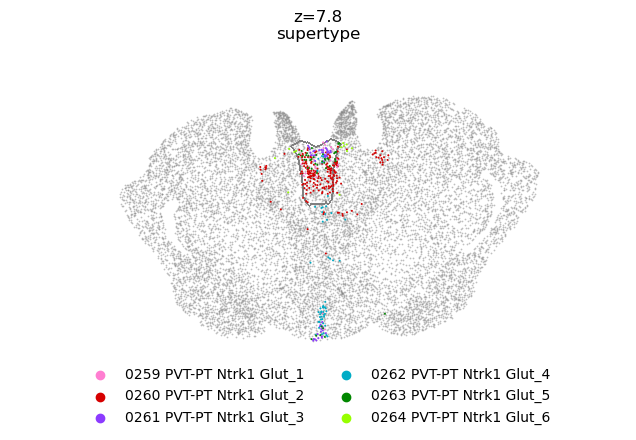

In [ ]:
pvt_sections = [7.0, 7.8]
nuclei = ['PVT']
subclasses = nuclei
obs = obs_th_neurons.loc[np.any([obs_th_neurons['subclass'].str.contains(x).values for x in subclasses], axis=0), :]
cplots.plot_ccf_overlay(obs, ccf_polygons, bg_cells=obs_th, point_hue='supertype', sections=pvt_sections,
                 shape_palette='dark_outline',
                 ccf_names=nuclei, legend='cells', bg_shapes=False, 
                 section_col=section_col)

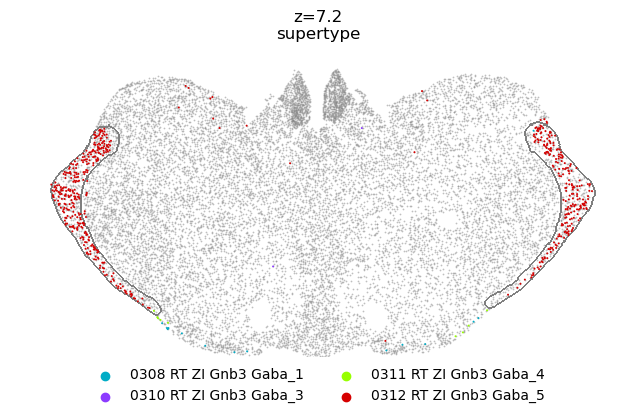

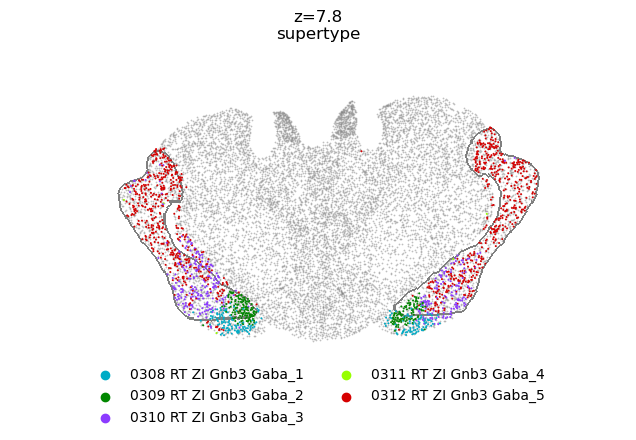

In [ ]:
rt_sections = [7.2, 7.8]
nuclei = ['RT']
subclasses = ['RT ZI']
obs = obs_th_neurons.loc[np.any([obs_th_neurons['subclass'].str.contains(x).values for x in subclasses], axis=0), :]
cplots.plot_ccf_overlay(obs, ccf_polygons, bg_cells=obs_th, point_hue='supertype', sections=rt_sections,
                 shape_palette='dark_outline',
                 ccf_names=nuclei, legend='cells', bg_shapes=False, 
                 section_col=section_col)

## subclass view of all sections

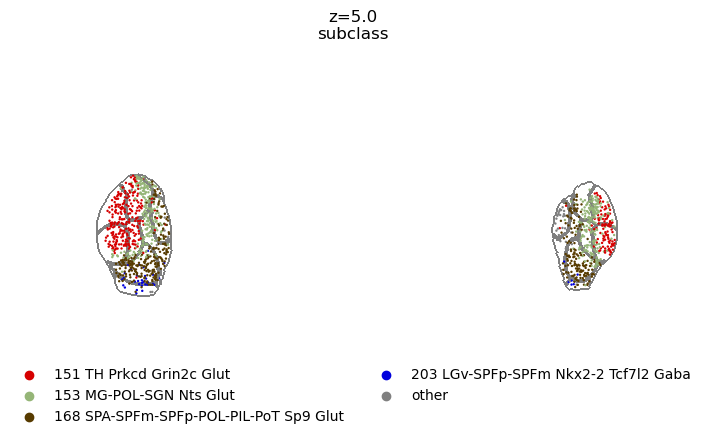

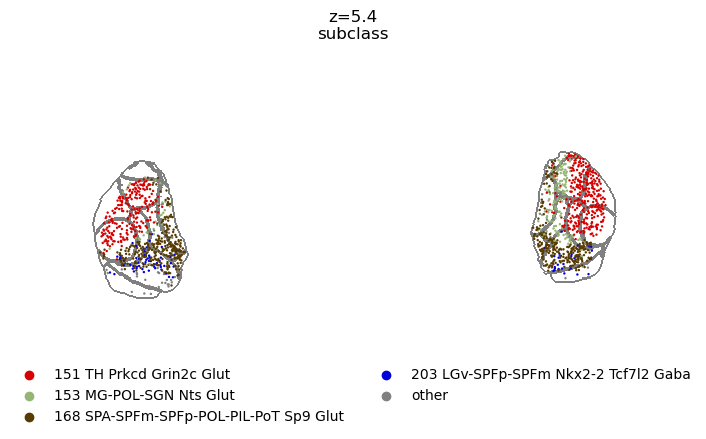

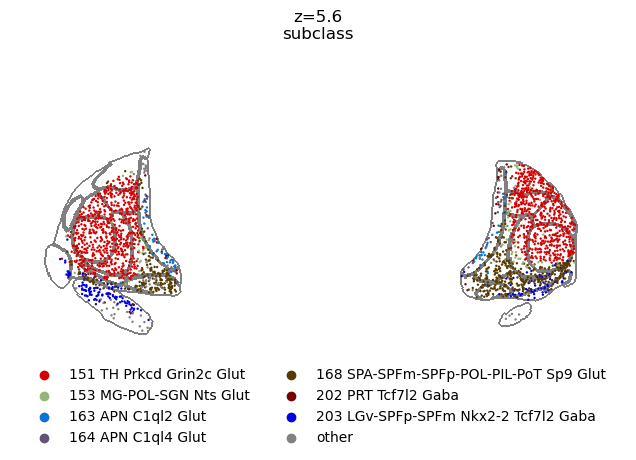

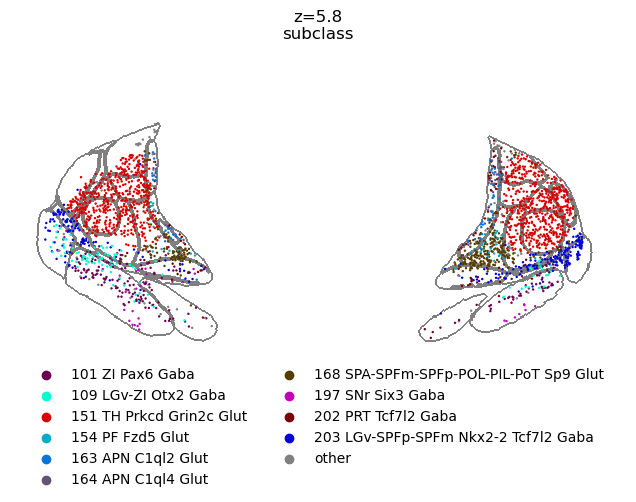

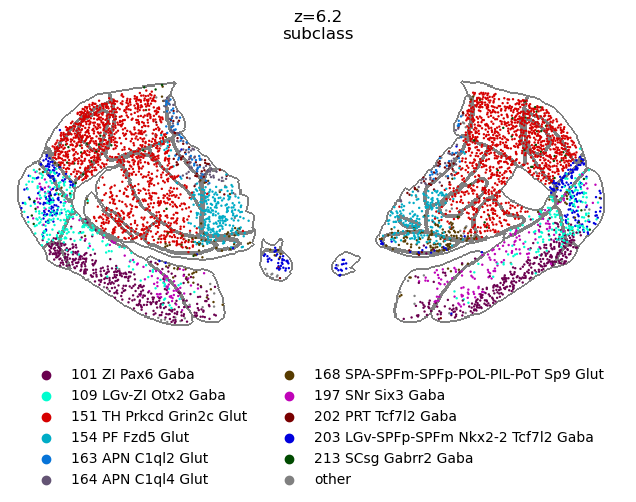

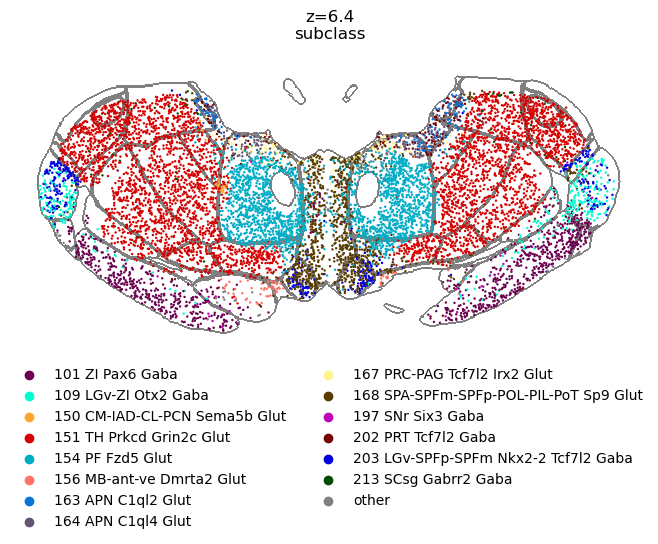

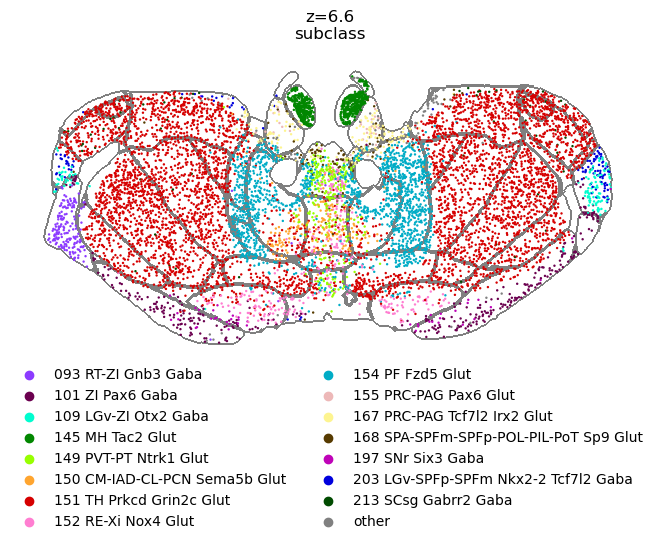

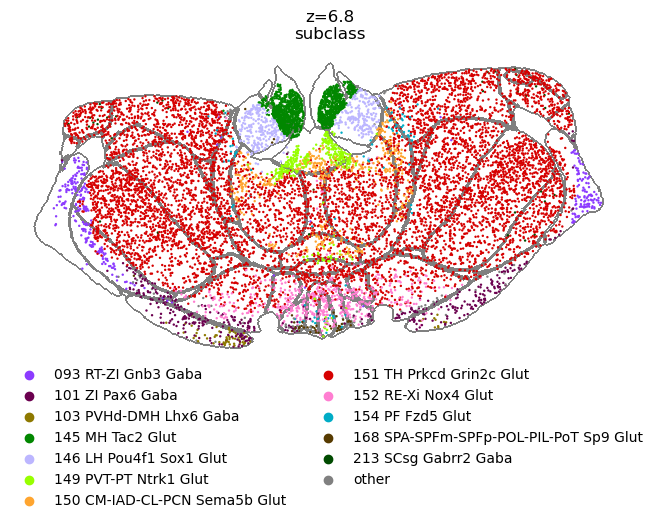

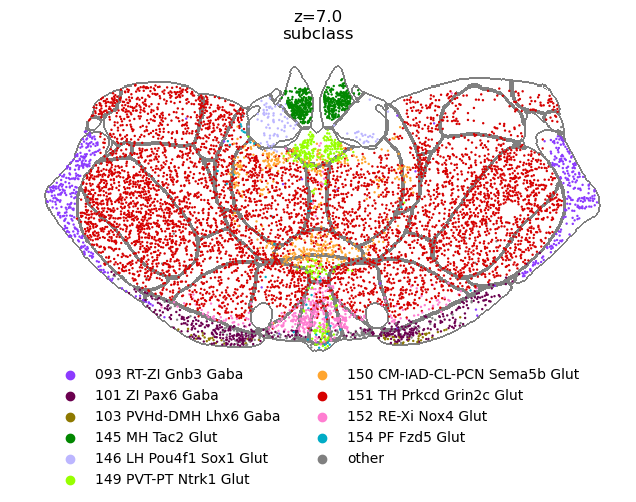

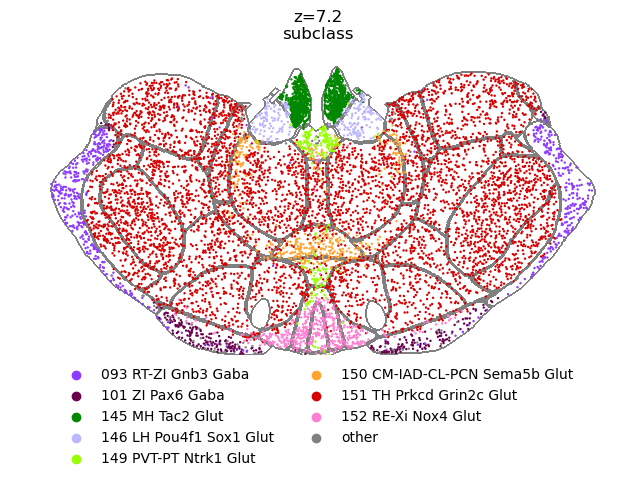

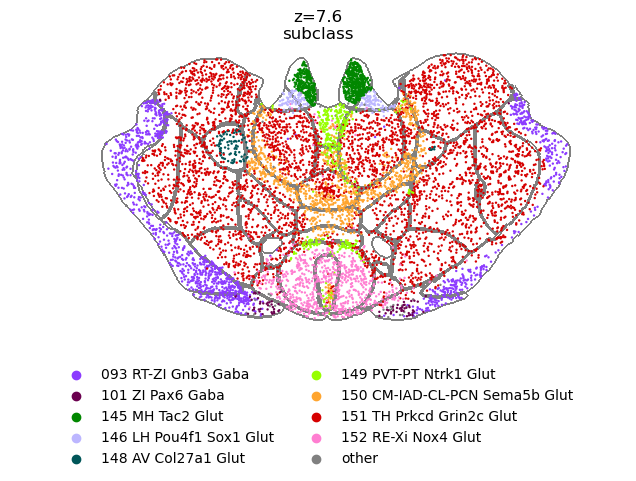

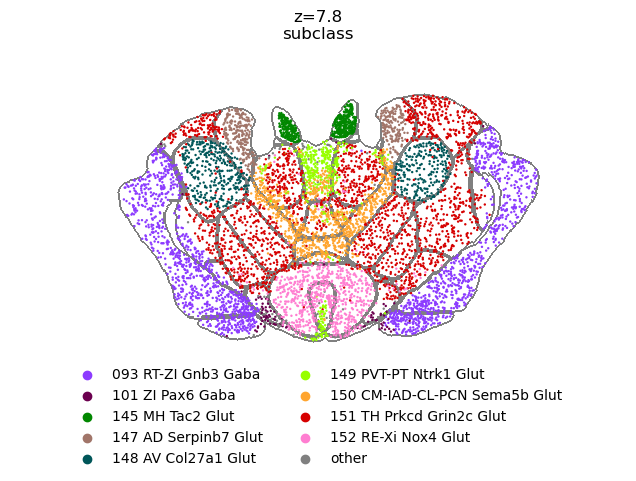

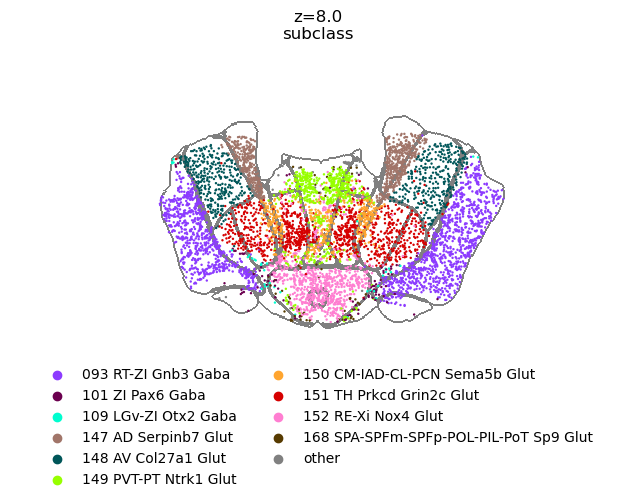

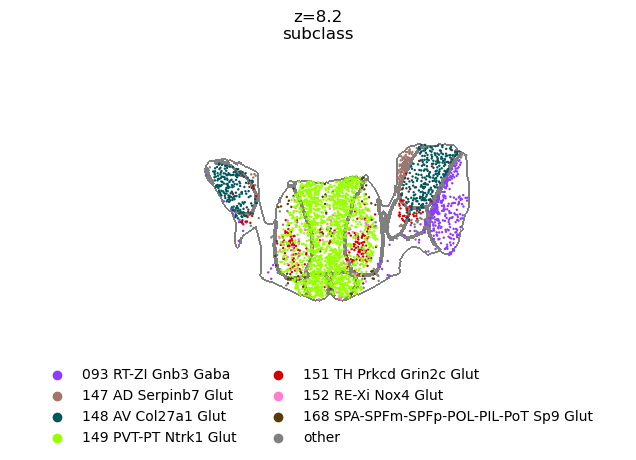

In [ ]:
obs = obs_th_neurons
cplots.plot_ccf_overlay(obs, ccf_polygons, 
                        # bg_cells=obs_th_neurons, # skip the background cells - it just makes it look like a grey 3D shadow on each dot
                        point_hue='subclass', sections=sections_all,
                        shape_palette='dark_outline', 
                        point_palette=None, 
                        legend='cells', highlight='all', 
                        section_col=section_col, x_col=x_coord_col, y_col=y_coord_col,
                        min_group_count=30, s=3)